# Oronto Group Subsidence Chron Modeling

Here I am trying to plot the subsidence chron age model from Julia to see if there have been improvements

In [24]:
using Chron
using Plots
using CSV
using DataFrames
using SubsidenceChron
using StatGeochem
using Distributions
using Statistics
using StatsBase

In [26]:
data_csv = importdataset("../../data/Strat/Subsidence.csv",',')
# Obtain stratigraphic info from the data file
nLayers = length(data_csv["Thickness"])
strat = NewStratData(nLayers)
strat.Lithology          = data_csv["Lithology"]
strat.Thickness         .= data_csv["Thickness"]

3-element Vector{Float64}:
 4000.0
  300.0
  750.0

In [27]:
wd_csv = importdataset("../../data/Strat/seq_strat.csv", ',')
# Obtain paleo water depth info from the data file
wd_nLayers = length(wd_csv["Thickness"])
wd = NewWaterDepth(wd_nLayers)
wd.DepthID    = wd_csv["Type"]
wd.Thickness .= wd_csv["Thickness"] 

3-element Vector{Float64}:
 4000.0
  300.0
  750.0

In [28]:
nsims = 5000
# Resolution for model horizons (in km)
res = 10
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Run the decompaction and backstripping MC model
# (wd input is optional)
@time (Sₜ, Sμ, Sσ, model_strat_heights) = DecompactBackstrip(strat, nsims, res)

([1936.7261274542486 2557.174764727933 … 2040.366324699832 2103.7869326936684; 1934.553009975222 2554.3577910251793 … 2038.1224380077003 2101.4531124397513; … ; 17.10655133650757 24.954566440034 … 16.139981767002585 21.503879110752845; 0.0 0.0 … 0.0 0.0], [2379.260476593919, 2376.8776136281735, 2374.487817442003, 2372.0910951823594, 2369.6874539268206, 2367.2769006838594, 2364.8594423930517, 2362.4350859253805, 2360.0038380834467, 2357.5657056017344  …  162.63487592702805, 147.08506015373018, 131.07133124012685, 114.54629171593956, 97.45250260543158, 79.71882222271498, 61.2546224833502, 41.93997621039068, 21.607210426617716, 0.0], [234.76640312768393, 234.54576609427085, 234.3256832406, 234.10614127062763, 233.88712695394796, 233.6686271253273, 233.45062868422292, 233.23311859431973, 233.01608388305095, 232.79951164112194  …  74.68343514144301, 69.14667503173567, 63.20176986206704, 56.781455290095515, 49.79898228479207, 42.139102843871584, 33.64268029305263, 24.07808292417249, 13.08103

In [ ]:
p1 = plot(Sμ, alpha = 1, yflip = true, xflip = true, label = "Tectonic subsidence", color = "blue")
#plot!(p1, reverse((model_strat_heights)*1000), yflip = true, label = "Present-day thickness", color = "red")
plot!(p1, Sₜ[:,2:end], alpha = 0.01, label = "", yflip = true, color = "blue", fg_color_legend=:white)

In [29]:
nSamples = 4
# Make an instance of a Chron Section object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("Sample 1", "Sample 2", "Sample 3","Sample 4") # Et cetera
smpl.Age          .= [   1085.6,   1078,    1052, 1050] # Measured ages
smpl.Age_sigma    .= [        0.65,       12,    0.85,5] # Measured 1-σ uncertainties
smpl.Height       .= [    1300,    1900,5800         ,6000] # Depths below surface should be negative
smpl.Height_sigma .= [     10,     100,          10,1000] # Usually assume little or no sample height uncertainty
smpl.Age_Sidedness .= [       0,        0,           -1,1] # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Age_Unit = "Ma" # Unit of measurement for ages
smpl.Height_Unit = "m" # Unit of measurement for Height and Height_sigma
# IMPORTANT: smpl.Height must increase with increasing stratigraphic height
# -- i.e., stratigraphically younger samples must be more positive. For this
# reason, it is convenient to represent depths below surface as negative
# numbers.
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


"m"

In [30]:
Beta = 3.0
Beta_sigma = 1.0
T0 = 1083
T0_sigma = 10

therm = NewThermalSubsidenceParameters()
therm.Param = [Beta, T0]
therm.Sigma = [Beta_sigma, T0_sigma]

2-element Vector{Float64}:
  1.0
 10.0

In [31]:
 # # # # # # # # # # Configure MCMC model here! # # # # # # # # # #
# Configure the stratigraphic MCMC model
config = NewStratAgeModelConfiguration()
# If you in doubt, you can probably leave these parameters as-is
config.resolution = res # Same units as sample height. Smaller is slower!
config.bounding = 1.0 # how far away do we place runaway bounds, as a fraction of total section height. Larger is slower.
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 200000 # Number of steps to run in distribution MCMC 
config.burnin = 10000*npoints_approx # Number to discard 
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

1413

In [32]:
#Run the model
(subsmdl, agedist, lldist, beta_t0dist, lldist_burnin) = SubsidenceStratMetropolis(smpl, config, therm, model_strat_heights, Sμ, Sσ, 0.05, 10)

(SubsidenceStratAgeModel([1300.0, 1310.0, 1320.0, 1330.0, 1340.0, 1350.0, 1360.0, 1370.0, 1380.0, 1390.0  …  5910.0, 5920.0, 5930.0, 5940.0, 5950.0, 5960.0, 5970.0, 5980.0, 5990.0, 6000.0], [1085.5107368872768, 1085.3915678701808, 1085.2696232558446, 1085.1497831786355, 1085.033329692649, 1084.9173592634477, 1084.8028015484922, 1084.691990727799, 1084.5824252107511, 1084.4724694233805  …  1046.1422185412882, 1046.089029584955, 1046.034631175176, 1045.98188193875, 1045.9280049803938, 1045.8736710752557, 1045.8193295741662, 1045.76298156216, 1045.7070269241335, 1045.6531214926404], [0.9117066900738967, 1.0097626248098628, 1.2022978691455186, 1.3791412662474025, 1.5331635053184445, 1.6718050123521448, 1.798343753557672, 1.91060734088376, 2.013215761601706, 2.1150698705429885  …  5.076729700895572, 5.096487247099941, 5.119169851750558, 5.1364606868322245, 5.15548543619781, 5.177065325020939, 5.198844746500707, 5.21962661407993, 5.239363231553158, 5.2590046525907574], [1085.508624352312, 10

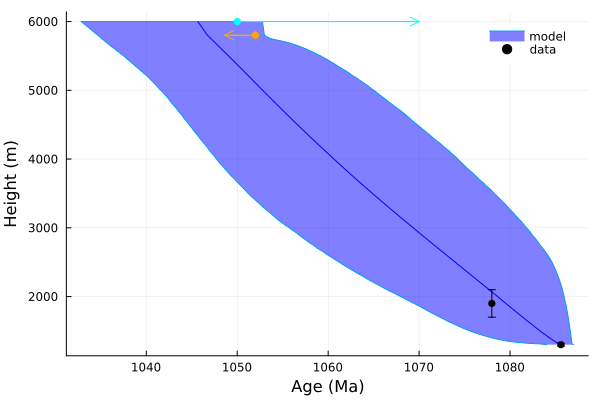

In [11]:
# Plot 1: Age-depth model (mean and 95% confidence interval for both model and data)
hdl = plot([subsmdl.Age_025CI; reverse(subsmdl.Age_975CI)],[subsmdl.Height; reverse(subsmdl.Height)], fill=(round(Int,minimum(subsmdl.Height)),0.5,:blue), label="model")
plot!(hdl, subsmdl.Age, subsmdl.Height, linecolor=:blue, label="", fg_color_legend=:white) # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],smpl.Age_975CI[t]-smpl.Age[t]),yerror=(2*smpl.Height_sigma[t]),label="data",seriestype=:scatter,color=:black)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],zeros(count(t))),label="",seriestype=:scatter,color=:cyan,msc=:cyan)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:cyan)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),smpl.Age_975CI[t]-smpl.Age[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Height ($(smpl.Height_Unit))")

In [12]:
mdl_ages=DataFrame((height=subsmdl.Height,age=subsmdl.Age,low_ci=subsmdl.Age_025CI,up_ci=subsmdl.Age_975CI))
data_path=joinpath("/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/subs_age_model.csv")
CSV.write(data_path,mdl_ages)

"/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/subs_age_model.csv"

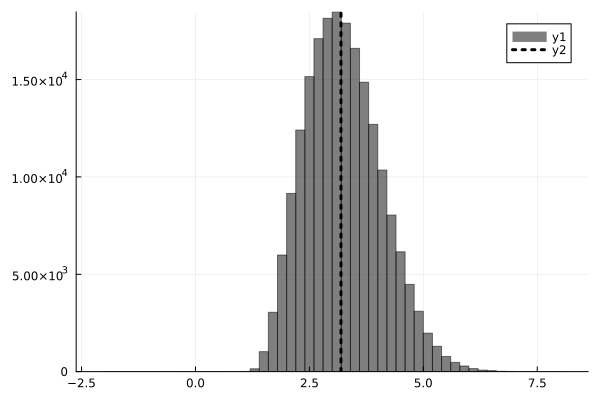

In [19]:
post_beta = histogram(beta_t0dist[1,:], color="black", linecolor=nothing, alpha = 0.5, nbins=50)
vline!([subsmdl.Beta_Median], linecolor = "black", linestyle=:dot, linewidth = 3)

In [13]:
sub_params=DataFrame((beta=beta_t0dist[1,:],t_s=beta_t0dist[2,:]))
data_path=joinpath("../../data/geochron/sub_params.csv")
CSV.write(data_path,sub_params)

"../../data/geochron/sub_params.csv"

In [ ]:
p1 = plot(framestyle=:box,
xlabel="Age [$(smpl.Age_Unit)]",
ylabel="Subsidence [m]", 
xflip = true,
yflip = true, 
legend = :bottomleft,
)
mean_age = linterp1s(subsmdl.Height, subsmdl.Age, maximum(subsmdl.Height).-model_strat_heights)
plot!(p1, mean_age, Sμ, alpha = 1, label = "Tectonic subsidence", color = "blue")
plot!(p1, mean_age, Sₜ, alpha = 0.01, label = "", color = "blue", fg_color_legend=:white)

vline!([subsmdl.T0_Median], linecolor = "black", linestyle=:dot, linewidth = 3,alpha=0.4)

In [12]:
mean_age

506-element Vector{Float64}:
 1045.616125358938
 1045.6731617766181
 1045.726673744861
 1045.7825135088171
 1045.8362484465865
 1045.8893526289633
 1045.9410262966512
 1045.9945756591546
 1046.0469074580103
 1046.1024941372393
    ⋮
 1088.750322440643
 1088.8705841306848
 1088.9908458207267
 1089.1111075107685
 1089.2313692008104
 1089.3516308908522
 1089.471892580894
 1089.592154270936
 1089.7124159609778

Here I am taking the model data and exporting to recreate figures in python 

In [15]:
st=DataFrame(permutedims(Sₜ), :auto)
s_mean=DataFrame((S=Sμ));
mid_age=DataFrame((mean_age=mean_age));

data_path=joinpath("/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/sub_mean.csv")
CSV.write(data_path,mid_age)

"/Users/anthonyfuentes/GitHub/Freda_Pmag/data/geochron/sub_mean.csv"

In [16]:
    # Stratigraphic height at which to interpolate
    height = 6000
    age_at_height = linterp1s(subsmdl.Height,subsmdl.Age,height)
    age_at_height_min = linterp1s(subsmdl.Height,subsmdl.Age_025CI,height)
    age_at_height_max = linterp1s(subsmdl.Height,subsmdl.Age_975CI,height)


    
 

1052.77520900651

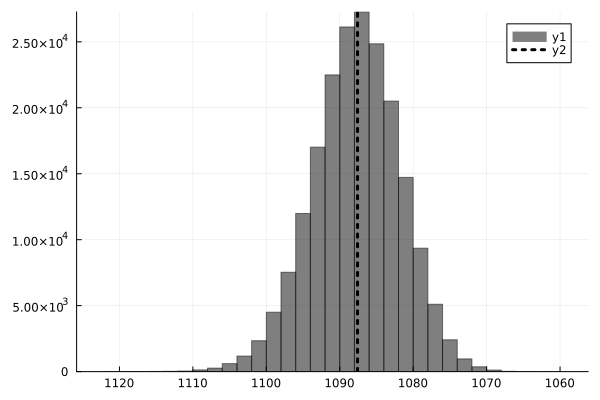

In [20]:
 # Plot 3: Posterior distributions of t₀
 post_t0 = histogram(beta_t0dist[2,:], color="black", linecolor=nothing, alpha = 0.5, nbins=50,xflip=true)
 vline!([subsmdl.T0_Median], linecolor = "black", linestyle=:dot, linewidth = 3)

## Nonesuch Age

In [17]:
    # Stratigraphic height at which to interpolate
    height = [1750,2050]
    age_at_height = linterp1s(subsmdl.Height,subsmdl.Age,height)
    age_at_height_min = linterp1s(subsmdl.Height,subsmdl.Age_025CI,height)
    age_at_height_max = linterp1s(subsmdl.Height,subsmdl.Age_975CI,height)



2-element Vector{Float64}:
 1086.3309339952518
 1085.8566618569278

In [18]:
age_at_height

2-element Vector{Float64}:
 1080.9299446093878
 1078.1668600014514

In [22]:
age_at_height_max-age_at_height

2-element Vector{Float64}:
 5.4009893858640226
 7.689801855476389

In [23]:
age_at_height-age_at_height_min

2-element Vector{Float64}:
  9.355483773660808
 10.916254105854932

#WRF Age

In [33]:
    # Stratigraphic height at which to interpolate
    height = [3720,2620,4820]
    age_at_height = linterp1s(subsmdl.Height,subsmdl.Age,height)
    age_at_height_min = linterp1s(subsmdl.Height,subsmdl.Age_025CI,height)
    age_at_height_max = linterp1s(subsmdl.Height,subsmdl.Age_975CI,height)

3-element Vector{Float64}:
 1076.4825166145195
 1084.0472333994733
 1066.8690234720925

In [34]:
age_at_height

3-element Vector{Float64}:
 1063.072860002416
 1072.9336372887765
 1054.212026296082

In [35]:
age_at_height_min

3-element Vector{Float64}:
 1049.8099629481967
 1059.8834276051452
 1042.8208948268375

In [36]:
age_at_height_max

3-element Vector{Float64}:
 1076.4825166145195
 1084.0472333994733
 1066.8690234720925